This is our baseline for Tumor Segmentation Task. All the code used for this project is modified and derived based on [this repo](https://github.com/avocadopelvis/BTP).

- Note: Please do not rerun the code since training is time-consuming (~4h);
- Code is tested on tiny-debug-cluster-gpu. 
## Load Libraries

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

import os
import cv2
# glob (short for global) is used to return all file paths that match a specific pattern.
import glob 

# PIL adds image processing capabilities to your Python interpreter.
import PIL
import PIL.Image
if not hasattr(PIL.Image, 'Resampling'):  # Pillow<9.0
    PIL.Image.Resampling = PIL.Image
from PIL import ImageOps

# Shutil module offers high-level operation on a file like a copy, create, and remote operation on the file.
import shutil

# skimage is a collection of algorithms for image processing and computer vision.
from skimage import data
from skimage.util import montage
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize


# NEURAL IMAGING
import nilearn as nl
import nibabel as nib # access a multitude of neuroimaging data formats
import nilearn.plotting as nlplt
# import gif_your_nifti.core as gif2nif


# ML Libraries
# import keras
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers.experimental import preprocessing

from ray.train.tensorflow import TensorflowTrainer

from ray import tune

# make numpy printouts easier to read
np.set_printoptions(precision = 3, suppress = True)

import warnings
warnings.filterwarnings('ignore')

## Data Visualization

All BraTS multimodal scans are available as NIfTI files (.nii.gz) and describe a) native (T1) and b) post-contrast T1-weighted (T1Gd), c) T2-weighted (T2), and d) T2 Fluid Attenuated Inversion Recovery (T2-FLAIR) volumes, and were acquired with different clinical protocols and various scanners from multiple (n=19) institutions. The data is collected from this [link](https://www.kaggle.com/datasets/awsaf49/brats20-dataset-training-validation). All the imaging datasets have been segmented manually, by one to four raters, following the same annotation protocol, and their annotations were approved by experienced neuro-radiologists. Annotations comprise the GD-enhancing tumor (ET — label 4), the peritumoral edema (ED — label 2), and the necrotic and non-enhancing tumor core (NCR/NET — label 1), as described both in the BraTS 2012-2013 TMI paper and in the latest BraTS summarizing paper. The provided data are distributed after their pre-processing, i.e., co-registered to the same anatomical template, interpolated to the same resolution (1 mm^3) and skull-stripped.

In [0]:
# dataset path
train_data = "/dbfs/FileStore/tables/BraTS2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/"
valid_data = "/dbfs/FileStore/tables/BraTS2020/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/"

Out[3]:

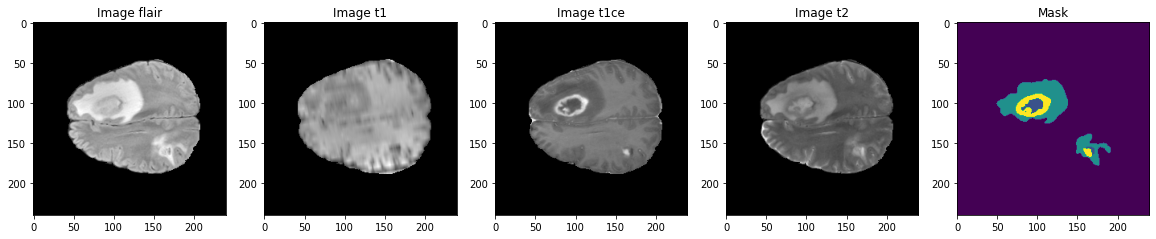

Text(0.5, 1.0, 'Mask')

In [0]:
id_img = '369'
test_image_flair = nib.load(train_data + f'BraTS20_Training_{id_img}/BraTS20_Training_{id_img}_flair.nii').get_fdata()
test_image_t1 = nib.load(train_data + f'BraTS20_Training_{id_img}/BraTS20_Training_{id_img}_t1.nii').get_fdata()
test_image_t1ce = nib.load(train_data + f'BraTS20_Training_{id_img}/BraTS20_Training_{id_img}_t1ce.nii').get_fdata()
test_image_t2 = nib.load(train_data + f'BraTS20_Training_{id_img}/BraTS20_Training_{id_img}_t2.nii').get_fdata()
test_mask = nib.load(train_data + f'BraTS20_Training_{id_img}/BraTS20_Training_{id_img}_seg.nii').get_fdata()

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize = (20, 10))
slice_w = 25

# FLAIR
ax1.imshow(test_image_flair[:,:,test_image_flair.shape[0]//2-slice_w], cmap = 'gray')
ax1.set_title('Image flair')

# T1
ax2.imshow(test_image_t1[:,:,test_image_t1.shape[0]//2-slice_w], cmap = 'gray')
ax2.set_title('Image t1')

# T1CE
ax3.imshow(test_image_t1ce[:,:,test_image_t1ce.shape[0]//2-slice_w], cmap = 'gray')
ax3.set_title('Image t1ce')

# T2
ax4.imshow(test_image_t2[:,:,test_image_t2.shape[0]//2-slice_w], cmap = 'gray')
ax4.set_title('Image t2')

# MASK
ax5.imshow(test_mask[:,:,test_mask.shape[0]//2-slice_w])
ax5.set_title('Mask')

Out[4]:

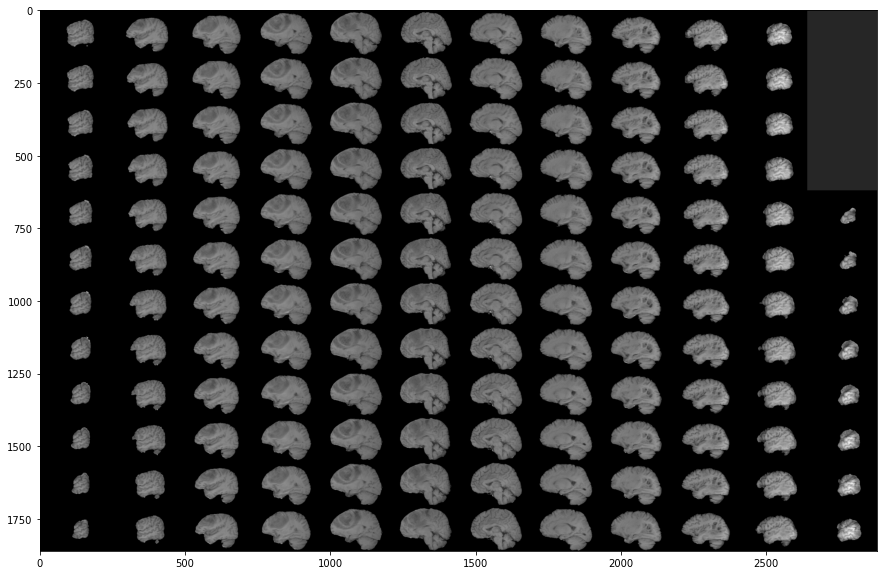

<matplotlib.image.AxesImage at 0x7f07e02e0760>

In [0]:
# skip 50:-50 slices since there is not much to see
fig, ax1 = plt.subplots(1, 1, figsize = (15, 15))
ax1.imshow(rotate(montage(test_image_t1[50:-50,:,:]), 90, resize = True), cmap = 'gray')

Out[5]:

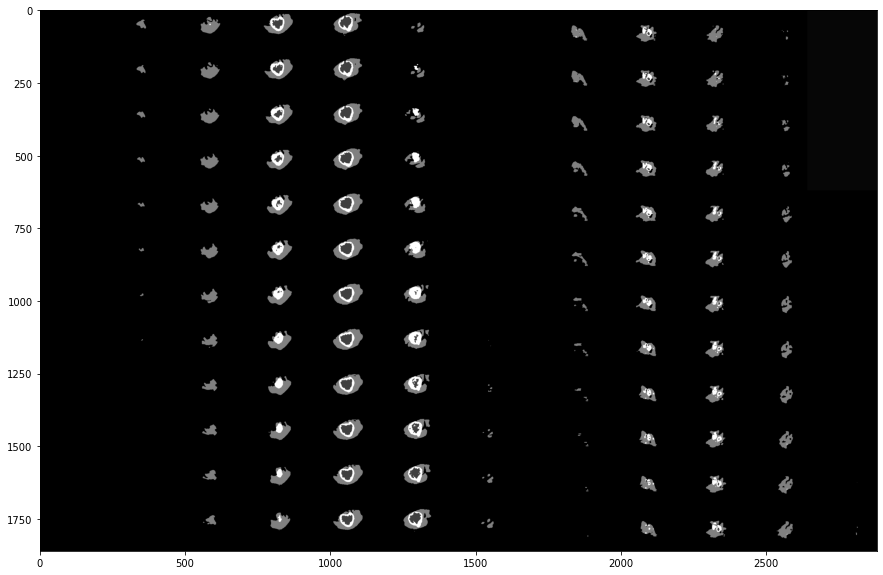

<matplotlib.image.AxesImage at 0x7f07e0252d00>

In [0]:
# skip 50:-50 slices since there is not much to see
fig, ax1 = plt.subplots(1, 1, figsize = (15, 15))
ax1.imshow(rotate(montage(test_mask[50:-50,:,:]), 90, resize = True), cmap = 'gray')

## Data Preparation

No handles with labels found to put in legend.

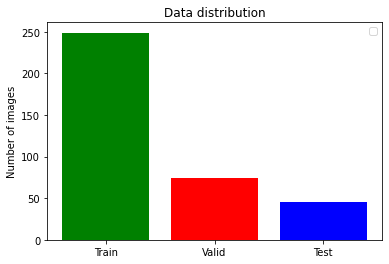

In [0]:
# list of directories
train_val_directories = [f.path for f in os.scandir(train_data) if f.is_dir()]

# remove BraTS20_Training_355 since it has ill formatted name for seg.nii file
train_val_directories.remove(train_data + 'BraTS20_Training_355')

# function to convert list of paths into IDs
def pathListIntoIDs(dirList):
  x = []
  for i in range(0, len(dirList)):
    x.append(dirList[i][dirList[i].rfind('/')+1:])
  return x

ids = pathListIntoIDs(train_val_directories)

# split ids into train+test and validation
train_test_ids, val_ids = train_test_split(ids, test_size = 0.2)
# split train+test into train and test                                           
train_ids, test_ids = train_test_split(train_test_ids, test_size = 0.15)

# function to display data distribution
def showDataLayout():
    plt.bar(["Train","Valid","Test"],
    [len(train_ids), len(val_ids), len(test_ids)], align='center',color=[ 'green','red', 'blue'])
    plt.legend()

    plt.ylabel('Number of images')
    plt.title('Data distribution')

    plt.show()
    
showDataLayout()

In [0]:
IMG_SIZE = 128

# define segmentation areas
SEGMENT_CLASSES = {
    0 : 'NOT TUMOR',
    1 : 'NECROTIC/CORE', # or NON-ENHANCING TUMOR CORE
    2 : 'EDEMA',
    3 : 'ENHANCING' # original 4 -> converted into 3 later
}

# there are 155 slices per volume
# to start at 5 and use 145 slices means we will skip the first 5 and last 5 
VOLUME_SLICES = 100 
VOLUME_START_AT = 22 # first slice of volume that we will include

# override keras sequence DataGenerator class
class DataGenerator(keras.utils.Sequence):
    # generates data for Keras
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1 , n_channels = 2, shuffle=True):
        # Initialization
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        # denotes the number of batches per epoch
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        # generate one batch of data

        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        # updates indexes after each epoch
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # initialization
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))
        Y = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, 4))

        
        # Generate data
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(train_data, i)

            data_path = os.path.join(case_path, f'{i}_flair.nii');
            flair = nib.load(data_path).get_fdata()    

            data_path = os.path.join(case_path, f'{i}_t1ce.nii');
            ce = nib.load(data_path).get_fdata()
            
            data_path = os.path.join(case_path, f'{i}_seg.nii');
            seg = nib.load(data_path).get_fdata()
        
            for j in range(VOLUME_SLICES):
                 X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
                 X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

                 y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];
                    
        # Generate masks
        y[y==4] = 3;
        mask = tf.one_hot(y, 4);
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE));
        return X/np.max(X), Y

In [0]:
training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)

## Training the model

tf.distribute.Strategy is a TensorFlow API to distribute training across multiple GPUs, multiple machines, or TPUs. Using this API, we can distribute our existing models and training code with minimal code changes.

tf.distribute.Strategy has been designed with these key goals in mind:

- Easy to use and support multiple user segments, including researchers, machine learning engineers, etc.
- Provide good performance out of the box.
- Easy switching between strategies.
- You can distribute training using tf.distribute.Strategy with a high-level API like Keras Model.fit, as well as custom training loops (and, in general, any computation using TensorFlow).

In TensorFlow 2.x, we can execute our programs eagerly, or in a graph using tf.function. tf.distribute.Strategy intends to support both these modes of execution, but works best with tf.function. Eager mode is only recommended for debugging purposes and not supported for tf.distribute.TPUStrategy. Although training is the focus of this guide, this API can also be used for distributing evaluation and prediction on different platforms.

tf.distribute.Strategy can be used with very few changes to the code, because the underlying components of TensorFlow have been changed to become strategy-aware. This includes variables, layers, models, optimizers, metrics, summaries, and checkpoints.

tf.distribute.MirroredStrategy supports synchronous distributed training on multiple GPUs on one machine. It creates one replica per GPU device. Each variable in the model is mirrored across all the replicas. Together, these variables form a single conceptual variable called MirroredVariable. These variables are kept in sync with each other by applying identical updates.

Efficient all-reduce algorithms are used to communicate the variable updates across the devices. All-reduce aggregates tensors across all the devices by adding them up, and makes them available on each device. It’s a fused algorithm that is very efficient and can reduce the overhead of synchronization significantly. There are many all-reduce algorithms and implementations available, depending on the type of communication available between devices. By default, it uses the NVIDIA Collective Communication Library (NCCL) as the all-reduce implementation.

Types of strategies

tf.distribute.Strategy intends to cover a number of use cases along different axes. Some of these axes are:

- Synchronous vs asynchronous training: These are two common ways of distributing training with data parallelism. In sync training, all workers train over different slices of input data in sync, and aggregating gradients at each step. In async training, all workers are independently training over the input data and updating variables asynchronously. Typically sync training is supported via all-reduce and async through parameter server architecture.
- Hardware platform: which is good for scaling our training onto multiple GPUs on one machine, or multiple machines in a network (with 0 or more GPUs each), or on Cloud TPUs.

In [0]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

strategy = tf.distribute.MirroredStrategy()
print("Number of devices: {}".format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1

In [0]:
# Losses
from keras_unet_collection import losses
# losses.dice, losses.dice_coef

# dice loss as defined above for 4 classes
def dice_coef_class(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
   #     K.print_tensor(loss, message='loss value for class {} : '.format(SEGMENT_CLASSES[i]))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
#    K.print_tensor(total_loss, message=' total dice coef: ')
    return total_loss

# define per class evaluation of dice coef
# inspired by https://github.com/keras-team/keras/issues/9395
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(y_true[:,:,:,1]) + K.sum(y_pred[:,:,:,1]) + epsilon) # I dont like squre

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection) / (K.sum(y_true[:,:,:,2]) + K.sum(y_pred[:,:,:,2]) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection) / (K.sum(y_true[:,:,:,3]) + K.sum(y_pred[:,:,:,3]) + epsilon)

# Computing Precision 
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

# Computing Sensitivity      
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [0]:
# U-NET
def build_unet(inputs, ker_init, dropout):
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)
    
    pool = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)
    
    
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(drop5))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv9)
    
    up = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv9))
    merge = concatenate([conv1,up], axis = 3)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    conv10 = Conv2D(4, (1,1), activation = 'softmax')(conv)
    
    return Model(inputs = inputs, outputs = conv10)


In [0]:
input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

save_path = "/dbfs/FileStore/tables/BraTS2020/"
# add callback for training process
csv_logger = CSVLogger(f'{save_path}training_baseline2.log', separator=',', append=False)

checkpoint_filepath = f'{save_path}checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

callbacks = [
      model_checkpoint_callback,
      keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001, verbose=1),
      csv_logger
    ]


In [0]:
# TRAIN MODEL
BATCH_SIZE = 1
training_generator = DataGenerator(train_ids, batch_size = BATCH_SIZE * strategy.num_replicas_in_sync )

K.clear_session()
with strategy.scope():
    model = build_unet(input_layer, 'he_normal', 0.2)
    
    model.compile(
    loss = "categorical_crossentropy",
    optimizer = keras.optimizers.Adam(learning_rate = 0.001),
    metrics = ['accuracy', tf.keras.metrics.MeanIoU(num_classes = 4), dice_coef_class, losses.dice, losses.dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing])
    
history =  model.fit(training_generator,
                    epochs=30,
                    steps_per_epoch=len(train_ids),
                    callbacks= callbacks,
                    validation_data = valid_generator
                    )  

# save the model
model.save(f"{save_path}model_baseline.h5")

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Epoch 1/30
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
 1/249 [..............................] - ETA: 1:45:26 - loss: 1.7051 - accuracy: 2.3682e-04 - mean_io_u: 0.3751 - dice_coef_class: 0.0792 - dice: 0.8144 - dice_coef: 0.1856 - precision: 0.0000e+00 - sensitivity: 0.0000e+00 - specificity: 0.9999 - dice_coef_necrotic: 1.8832e-04 - dice_coef_edema: 0.0013 - dice_coef_enhancing: 0.0024 2/249 [..............................] - ETA: 2:37 - loss: 1.4546 - accuracy: 0.1334 - mean_io_u: 0.3753 - dice_coef_class: 0.1008 - dice: 0.7553 - dice_coef: 0.2447 - precision: 5.0050e-04 - sensitivity: 3.0518e-07 - specificity: 0.9996 - dice_coef_necrotic: 1.2080e-04 - dice_coef_edema: 0.0118 - dice_coef_enhancing: 0.0028  3/249 [..............................] - ETA: 2:38 - loss: 1.4854 - accuracy: 0.4089 - mean_io_u: 0.4550 - dice_coef_class: 0.1474 - dice: 0.5275 - dice_coef: 0.4725 - precision: 0.3227 - sensitivity: 0.3129 - specificity: 0.9962 - dice_coef_necrotic: 8.0531e-05 - dice_coef_edema: 0.0079 - dice_coef_enhancing: 0.0019  4/249 [..............................] - ETA: 2:33 - loss: 1.2769 - accuracy: 0.5538 - mean_io_u: 0.4351 - dice_coef_class: 0.1555 - dice: 0.5070 - dice_coef: 0.4930 - precision: 0.4887 - sensitivity: 0.3757 - specificity: 0.9965 - dice_coef_necrotic: 1.0772e-04 - dice_coef_edema: 0.0072 - dice_coef_enhancing: 0.0015

## Evaluation

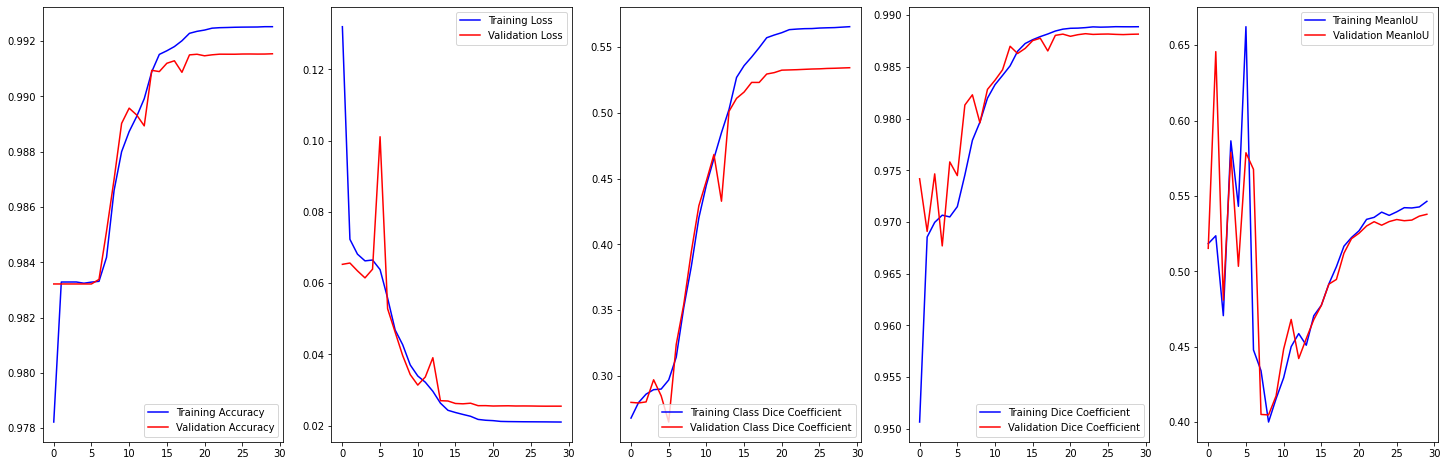

In [0]:
# load trained model
model = build_unet(input_layer, 'he_normal', 0.2)
model.load_weights(checkpoint_filepath)

# load training history
history = pd.read_csv(f"{save_path}training_baseline2.log", sep = ',', engine = 'python')

acc = history['accuracy']
val_acc = history['val_accuracy']

epoch = range(len(acc))

loss = history['loss']
val_loss = history['val_loss']

dice_class = history['dice_coef_class']
val_dice_class = history['val_dice_coef_class']

dice = history['dice_coef']
val_dice = history['val_dice_coef']

mean_iou = history['mean_io_u']
val_mean_iou = history['val_mean_io_u']

# visualize the training process
f, ax = plt.subplots(1, 5, figsize = (25, 8))

# ACCURACY
ax[0].plot(epoch, acc, 'b', label = 'Training Accuracy')
ax[0].plot(epoch, val_acc, 'r', label = 'Validation Accuracy')
ax[0].legend()

# LOSS
ax[1].plot(epoch, loss, 'b', label = 'Training Loss')
ax[1].plot(epoch, val_loss, 'r', label = 'Validation Loss')
ax[1].legend()

# CLASS DICE COEFFICIENT
ax[2].plot(epoch, dice_class, 'b', label = 'Training Class Dice Coefficient')
ax[2].plot(epoch, val_dice_class, 'r', label = 'Validation Class Dice Coefficient')
ax[2].legend()

# DICE COEFFICIENT
ax[3].plot(epoch, dice, 'b', label = 'Training Dice Coefficient')
ax[3].plot(epoch, val_dice, 'r', label = 'Validation Dice Coefficient')
ax[3].legend()

# Mean IoU
ax[4].plot(epoch, mean_iou, 'b', label = 'Training MeanIoU')
ax[4].plot(epoch, val_mean_iou, 'r', label = 'Validation MeanIoU')
ax[4].legend()

plt.show()

1/4 [======>.......................] - ETA: 21s4/4 [==============================] - ETA: 0s 4/4 [==============================] - 8s 320ms/step

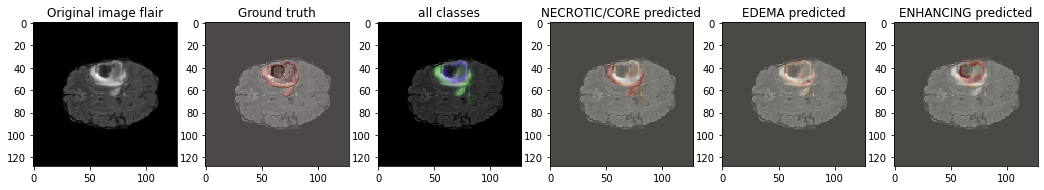

In [0]:
def predictByPath(case_path,case):
    files = next(os.walk(case_path))[2]
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))
  #  y = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE))
    
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii');
    flair=nib.load(vol_path).get_fdata()
    
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii');
    ce=nib.load(vol_path).get_fdata() 
    
 #   vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_seg.nii');
 #   seg=nib.load(vol_path).get_fdata()  

    
    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
 #       y[j,:,:] = cv2.resize(seg[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        
  #  model.evaluate(x=X,y=y[:,:,:,0], callbacks= callbacks)
    return model.predict(X/np.max(X), verbose=1)


def showPredictsById(case, start_slice = 60):
    path = f"/dbfs/FileStore/tables/BraTS2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
    gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
    origImage = nib.load(os.path.join(path, f'BraTS20_Training_{case}_flair.nii')).get_fdata()
    p = predictByPath(path, case)

    core = p[:,:,:,1]
    edema= p[:,:,:,2]
    enhancing = p[:,:,:,3]

    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1,6, figsize = (18, 50)) 

    for i in range(6): # for each image, add brain background
        axarr[i].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray", interpolation='none')
    
    axarr[0].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[0].title.set_text('Original image flair')
    curr_gt=cv2.resize(gt[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
    axarr[1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.3) # ,alpha=0.3,cmap='Reds'
    axarr[1].title.set_text('Ground truth')
    axarr[2].imshow(p[start_slice,:,:,1:4], cmap="Reds", interpolation='none', alpha=0.3)
    axarr[2].title.set_text('all classes')
    axarr[3].imshow(edema[start_slice,:,:], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[3].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')
    axarr[4].imshow(core[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[4].title.set_text(f'{SEGMENT_CLASSES[2]} predicted')
    axarr[5].imshow(enhancing[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[5].title.set_text(f'{SEGMENT_CLASSES[3]} predicted')
    plt.show()
    
showPredictsById(case = test_ids[3][-3:])

1/4 [======>.......................] - ETA: 0s2/4 [==============>...............] - ETA: 0s3/4 [=====================>........] - ETA: 0s4/4 [==============================] - ETA: 0s4/4 [==============================] - 0s 66ms/step

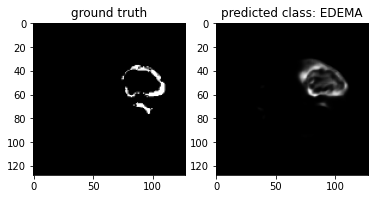

In [0]:
case = test_ids[4][-3:]
path = f"/dbfs/FileStore/tables/BraTS2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"

# ground truth
gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()

p = predictByPath(path, case)

core = p[:, :, :, 1]
edema = p[:, :, :, 2]
enhancing = p[:, :, :, 3]

# slice at
i = 40
eval_class = 2

# use only one class for per class evaluation 
gt[gt != eval_class] = 1

resized_gt = cv2.resize(gt[:,:,i+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

plt.figure()
f, axarr = plt.subplots(1,2) 
axarr[0].imshow(resized_gt, cmap="gray")
axarr[0].title.set_text('ground truth')
axarr[1].imshow(p[i,:,:,eval_class], cmap="gray")
axarr[1].title.set_text(f'predicted class: {SEGMENT_CLASSES[eval_class]}')
plt.show()